In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Loading data

In [257]:
with open('../names.txt', 'r') as file:
    names = file.read().split()

print('Total names:', len(names))
print(names[:5])

Total names: 32033
['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [3]:
# Form stoi and itos
vocab = sorted(list(set(''.join(names))))
stoi = {s: i+1 for i, s in enumerate(vocab)}
stoi['.'] = 0
itos = {stoi[s]: s for s in stoi}

In [160]:
block_size = 3
X = []
Y = []

for word in names:
    word = ['.']*block_size + list(word) + ['.']
    for ind in range(3, len(word)):
        X.append([stoi[x] for x in word[ind-3:ind]])
        Y.append(stoi[word[ind]])
        # print(''.join(word[ind-3:ind]), '--->', word[ind])

X = torch.tensor(X)
Y = torch.tensor(Y)

In [161]:
X.shape, Y.shape, X.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64)

In [258]:
X[0]

tensor([0, 0, 0])

### Data Indexing
Indexing 27 characters in 2D space. Therefore, the dimension of `C` is `27 x 2`

In [ ]:
# 27 is vocab_size and 2 is the embedding dimension
C = torch.randn(27, 2)

In [72]:
C[0], C.dtype

(tensor([-1.8310, -2.0545]), torch.float32)

In [ ]:
emb = C[X]
print(emb[0]) # This encodes all 3 elements of X[0]
print(emb.shape) # All the integers in X are embedded in 2D

tensor([[0.4994, 0.0596],
        [0.4994, 0.0596],
        [0.4994, 0.0596]], grad_fn=<SelectBackward0>)
torch.Size([228146, 3, 2])


### Hidden layer

- `W1` weights are initialized randomly
- Number of inputs to hidden layer is `block_size * 2` or 3*2. We have encoded every character in the X to 2D space using `C`
- Transform the input embedding shape from `num x 3 x 2` to `num x 6`. This enables matrix multiplication `emb @ W1`

In [74]:
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [75]:
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

In [78]:
# output of the hidden layer
h = emb.view(emb.shape[0], 6) @ W1 + b1

# We can also do -1 instead of shape, pytorch will infer the value.

In [79]:
h = torch.tanh(h) # numbers between -1 and 1

In [80]:
# h.shape[0]: number of entries in dataset
# h.shape[1]: number of neurons we chose
h.shape

torch.Size([32, 100])

### Output layer

In [81]:
# Now we need to get probability distribution over 27 characters. 
W2 = torch.randn(100, 27)
b2 = torch.rand(27)

logits = (h @ W2) + b2

In [82]:
counts = logits.exp()

In [83]:
probs = counts / counts.sum(1, keepdims=True)

In [247]:
probs.shape, probs[0].sum()

(torch.Size([228146, 27]), tensor(1., grad_fn=<SumBackward0>))

In [86]:
probs[torch.arange(X.shape[0]), Y]

tensor([1.6911e-05, 1.2131e-07, 1.1433e-06, 2.8225e-10, 4.1201e-08, 2.6069e-11,
        2.3683e-10, 4.7285e-05, 3.7934e-11, 9.4034e-07, 2.2148e-07, 9.7094e-07,
        1.3954e-09, 2.4389e-07, 8.8684e-03, 3.1274e-10, 9.7286e-06, 5.3712e-12,
        3.0116e-03, 1.6982e-04, 1.3049e-06, 8.7927e-11, 3.6239e-13, 4.6360e-12,
        1.5429e-09, 1.2455e-09, 2.1575e-11, 6.5571e-05, 1.9210e-16, 1.9229e-07,
        9.0600e-06, 9.1933e-05])

In [89]:
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(17.3849)

In [248]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27, 2)
W1 = torch.randn(6, 100)
b1 = torch.randn(100)
W2 = torch.randn(100, 27)
b2 = torch.rand(27)
parameters = (C, W1, b1, W2, b2)

sum(p.nelement() for p in parameters)

3481

In [249]:
for p in parameters:
    p.requires_grad = True

In [187]:
# forward pass
emb = C[X]
h = torch.tanh((emb.view(-1, 6) @ W1) + b1)
logits = (h @ W2) + b2
print(logits.shape)
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
loss = -probs[torch.arange(Y.shape[0]), Y].log().mean()
loss

torch.Size([228146, 27])


tensor(19.3273, grad_fn=<NegBackward0>)

In [100]:
#backward pass
for p in parameters:
    p.grad = None

loss.backward()

for p in parameters:
    p.data += -0.1 * p.grad

In [252]:
lri = []
lossi = []

In [255]:
for ind in range(1000):
    # indices of data points in mini batch
    inds = torch.randint(low=0, high=X.shape[0], size=(32,))
    
    emb = C[X[inds]] # 32 x 3 x 2
    h = torch.tanh((emb.view(-1, 6) @ W1) + b1)
    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, Y[inds])
    # print(loss.item())
    lossi.append(loss.item())
    lri.append(steps[ind])
    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

2.3233444690704346


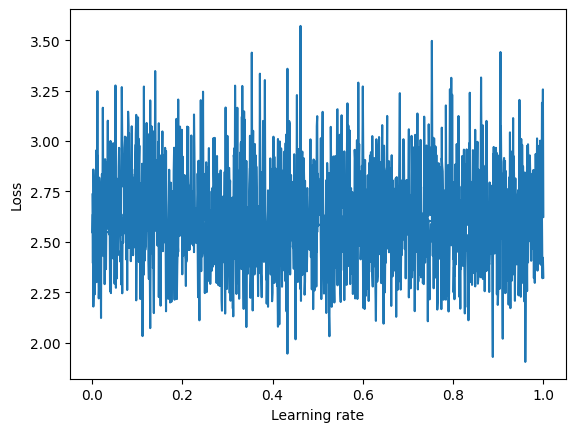

In [256]:
plt.plot(lri, lossi)
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.show()

In [ ]:
## Minibatch construction
res = X[torch.randint(low=0, high=228146, size=(32,))]
res.shape

### Determining learning rate
- You can plot loss of y-axis and learning rate on x-axis to find the best value or ranges for learning rate. 
- Below is the graph showing both linear and log of 
- In steps2, learning rate will be very very low (close to 0.001) but it will approach 1 fast as the number of steps increases.

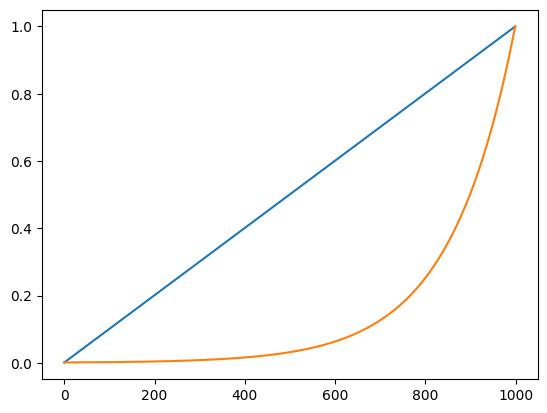

In [ ]:
steps = torch.linspace(0.001, 1, 1000)
plt.plot(steps)
steps2 = 10 ** torch.linspace(-3, 0, 1000)
plt.plot(steps2)
plt.show()

# Learning rate values are achieved by powering to 10
learning_rate_values = 10 ** torch.linspace(-3, 0, 1000)